In [1]:
import torch 
import pandas as pd
from torch.utils.data import random_split,DataLoader,TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Problema 1

In [2]:
dataset = pd.read_csv("dataset.csv")
dataset.drop("#",axis=1,inplace=True)
dataset

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


### Descripción del dataset  
En el siguiente bloque describa el dataset a utilizar. También es necesario hacer un análisis exploratorio de los datos.
Responda como mínimo las siguientes preguntas:
- ¿De qué trata el dataset?
- ¿Cuáles son las clases de salida?
- ¿Está preparado para poder ser introducido a una red neuronal?
- ¿Cuantas carácteristicas tiene?
- Etc.


In [3]:
dataset.describe()


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


### Descripción del dataset
El dataset trata de datos de pokemon, el el cual se tiene informacion de su: nombre, , tipo de pokemon, hp, ataque, defensa, ataque especial, defensa especial, velocidadgeneracion y si es legendario o no, siendo estala clase de salida.

### Preparación del dataset
El dataset no esta preparado para ser ingresado a una red neuronal, existen datos nulos y datos que no son numericos ,estos no son bien manejados por las redes neuronales, para lo cual se necesita elimninar la columna nombre yaque esta no entrega valor al datset para clasificar, se hace un hot-encodign a las columnas "Type 1" y "Type 2" para que puedan ser manejadas por la red neuronal

In [4]:
# Verificar valores nulos en el dataset
print(dataset.isnull().sum())

Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


In [5]:
# Eliminacion de columnas que no aportan,mas cambiar los tipos a mas columnas para que sean usados por el modelo
nombres = dataset['Name'].values # guardar los nombres de los pokemons

dataset = dataset.drop(columns=['Name','Total']) 
# El nombre de los pokemons se elimina ya, no aporta
# y el total tampoco aporta, ya que es la suma de los stats y estos se usan como entradas

# convertir las columnas de typos en a columnas separadas y entonces los nulos quedran como 0 o false
dataset=pd.get_dummies(dataset,columns=["Type 1","Type 2"], dummy_na= True) # convertir a columnas separadas los type1 y type2 
dataset.head()

dataset = dataset.drop(columns=['Type 1_nan', 'Type 2_nan']) # eliminar las columnas que no aportan nada

# Verificar valores nulos en el dataset
print(dataset.isnull().sum())

HP                 0
Attack             0
Defense            0
Sp. Atk            0
Sp. Def            0
Speed              0
Generation         0
Legendary          0
Type 1_Bug         0
Type 1_Dark        0
Type 1_Dragon      0
Type 1_Electric    0
Type 1_Fairy       0
Type 1_Fighting    0
Type 1_Fire        0
Type 1_Flying      0
Type 1_Ghost       0
Type 1_Grass       0
Type 1_Ground      0
Type 1_Ice         0
Type 1_Normal      0
Type 1_Poison      0
Type 1_Psychic     0
Type 1_Rock        0
Type 1_Steel       0
Type 1_Water       0
Type 2_Bug         0
Type 2_Dark        0
Type 2_Dragon      0
Type 2_Electric    0
Type 2_Fairy       0
Type 2_Fighting    0
Type 2_Fire        0
Type 2_Flying      0
Type 2_Ghost       0
Type 2_Grass       0
Type 2_Ground      0
Type 2_Ice         0
Type 2_Normal      0
Type 2_Poison      0
Type 2_Psychic     0
Type 2_Rock        0
Type 2_Steel       0
Type 2_Water       0
dtype: int64


Eliminacion de los valores nulos y reemplazo por la media de cada columna, para que no afecte a los datos de entrenamiento y no se eliminen filas que pueden ser importantes para el modelo.

Escalado de los datos para evitar que las caracteristicas con mayor rango de valores afecten el entrenamiento del modelo, y divicion de los datos para las caracteristicas y la salida.

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = dataset.drop(columns=["Legendary"])
X = X.astype(np.float32)
X_scaled = scaler.fit_transform(X)  # Normalizar las características
Y = dataset["Legendary"].astype('int').values    # Convertir a entero

### Preparación del dataset  
En el siguiente bloque realice la preparación del dataset. Esto incluye:
- Paso a tensores de PyTorch
- División del dataset en train y test
- Carga de los datos en DataLoader
- Otros pasos que considere necesarios

In [7]:
from sklearn.model_selection import train_test_split

# División del dataset en conjunto de entrenamiento y prueba
# 60% entrenamiento, 40% test
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.4, random_state=4, stratify=Y)

In [8]:
# 8. Convierte a tensores
X_train_t = torch.from_numpy(X_train)         # float32
Y_train_t = torch.from_numpy(Y_train)         # int64
X_test_t  = torch.from_numpy(X_test)
Y_test_t  = torch.from_numpy(Y_test)

In [9]:
# Crear TensorDataset y DataLoader para entrenamiento y test
Batch_size = 32  # Tamaño del batch
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)

### Implementación de la red neuronal
En el siguiente bloque implemente la arquitectura de red neuronal que predecirá si un Pokémon es legendario o no.

In [10]:
import torch.nn as nn

En el siguiente bloque cree una instancia de la red neuronal y defina la función de pérdida y el optimizador. Justifique la elección de la función de pérdida y el optimizador.

In [11]:
import torch.nn.functional as F

class PokemonNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=4):
        super(PokemonNet, self).__init__()
        # Capa de entrada → capa oculta
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Normalización para estabilizar el entrenamiento
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        # Capa oculta → segunda capa oculta, reduccion de input a la mitad
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2) 
        # Salida a 2 clases (no legendary / legendary)
        self.out = nn.Linear(hidden_dim // 2, 2)

    def forward(self, x):
        # x: [batch_size, input_dim]
        # Aplicar la primera capa lineal y luego utiliza los batch
        # para que la salida sea mas estable 
        x = F.relu(self.bn1(self.fc1(x)))
        # Aplicar la segunda capa lineal y luego una activación ReLU
        x = F.relu(self.fc2(x))
        # Aplicar la capa de salida
        # que no tiene activacion, porque se usara con CrossEntropyLoss
        logits = self.out(x)
        return logits  

En el siguiente bloque entrene la red neuronal.

In [12]:
input_dim = X_train_t.shape[1]          # cantidad de features
model = PokemonNet(input_dim, hidden_dim=64)  # Definir el modelo con 64 neuronas en la capa oculta 

# 1. Definir función de pérdida
# usare CrossEntropyLoss, yaque
# es la mas adecuada para clasificación multiclase y ademas la mas usada.
criterion = nn.CrossEntropyLoss()    
# 2. Definir optimizador y tasa de aprendizaje 
# Usaremos Adam, que es un optimizador adaptativo
# ayuda a converger mas rapido que SGD y ademas combina
# las ventajas de RMSProp y AdaGrad. por lo que es muy usado
# y es una buena opción para la mayoría de los problemas.

lering_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lering_rate)

# 3. entrenamiento del modelo
## Guardar epocas y sus perdidas
epochs = []
losses = []

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.float()
            yb = yb.long()  
            optimizer.zero_grad() # Reinica los gradientes
            preds = model(xb) # predicciones [clase 0 = no legendary, clase 1 = legendary]
            loss = criterion(preds, yb)  # Calcula la pérdida 
            loss.backward() # backpropagation y guardar los gradientes
            optimizer.step() # Ajusta los parametros del modelo
            running_loss += loss.item() * xb.size(0)
        # Guardar la perdida de la epoca
        epochs.append(epoch)
        epoch_loss = running_loss / len(train_loader.dataset) # type: ignore
        losses.append(epoch_loss)
        print(f"Epoch {epoch:02d} — Loss: {epoch_loss:.4f}")

# entrenamiento del modelo
train_model(model, train_loader, criterion, optimizer, num_epochs=100)

Epoch 01 — Loss: 0.5485
Epoch 02 — Loss: 0.3384
Epoch 03 — Loss: 0.2513
Epoch 04 — Loss: 0.2132
Epoch 05 — Loss: 0.1765
Epoch 06 — Loss: 0.1570
Epoch 07 — Loss: 0.1335
Epoch 08 — Loss: 0.1186
Epoch 09 — Loss: 0.1099
Epoch 10 — Loss: 0.0894
Epoch 11 — Loss: 0.0774
Epoch 12 — Loss: 0.0657
Epoch 13 — Loss: 0.0619
Epoch 14 — Loss: 0.0464
Epoch 15 — Loss: 0.0473
Epoch 16 — Loss: 0.0446
Epoch 17 — Loss: 0.0448
Epoch 18 — Loss: 0.0407
Epoch 19 — Loss: 0.0429
Epoch 20 — Loss: 0.0308
Epoch 21 — Loss: 0.0378
Epoch 22 — Loss: 0.0335
Epoch 23 — Loss: 0.0261
Epoch 24 — Loss: 0.0259
Epoch 25 — Loss: 0.0199
Epoch 26 — Loss: 0.0213
Epoch 27 — Loss: 0.0303
Epoch 28 — Loss: 0.0169
Epoch 29 — Loss: 0.0165
Epoch 30 — Loss: 0.0162
Epoch 31 — Loss: 0.0214
Epoch 32 — Loss: 0.0251
Epoch 33 — Loss: 0.0186
Epoch 34 — Loss: 0.0201
Epoch 35 — Loss: 0.0143
Epoch 36 — Loss: 0.0171
Epoch 37 — Loss: 0.0170
Epoch 38 — Loss: 0.0184
Epoch 39 — Loss: 0.0275
Epoch 40 — Loss: 0.0175
Epoch 41 — Loss: 0.0092
Epoch 42 — Loss:

En el siguiente bloque evalue el rendimiento de la red (Métricas de evaluación, matriz de confusión, etc.) y responda las siguientes preguntas:
- ¿Cuántas épocas fueron necesarias para converger?
- ¿Cuál fue la precisión final?
- ¿El entrenamiento de su red neuronal fue exitoso?
- ¿Cuales son los ejemplos que más confunde a la red neuronal? Responda el porqué de acuerdo a su conocimiento del dataset.




Reporte de clasificación:
               precision    recall  f1-score   support

No Legendary     0.9635    0.9864    0.9748       294
   Legendary     0.7895    0.5769    0.6667        26

    accuracy                         0.9531       320
   macro avg     0.8765    0.7817    0.8207       320
weighted avg     0.9493    0.9531    0.9498       320

Precisión (accuracy): 0.953125


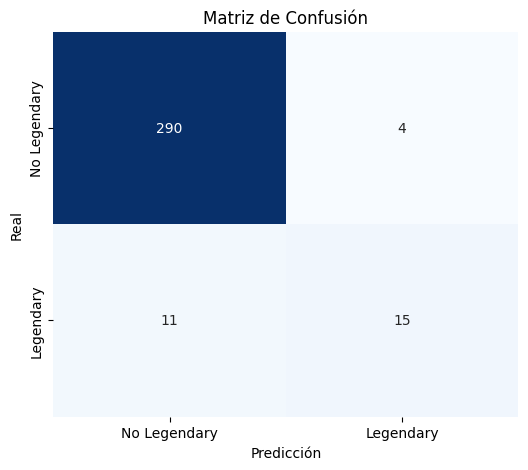

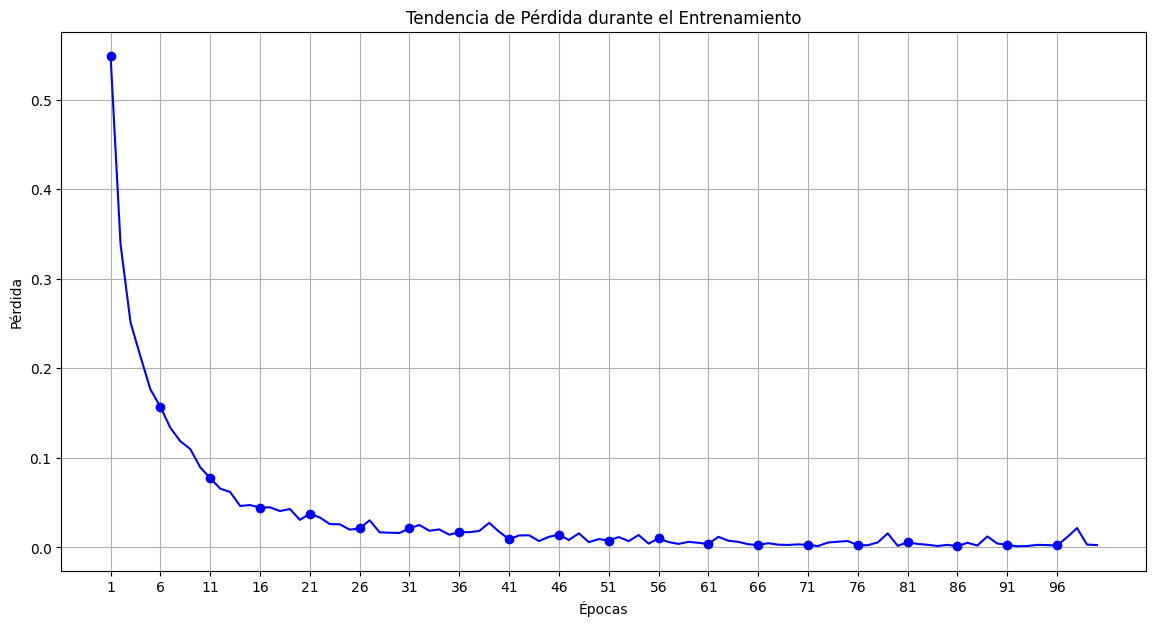


Pokémon clasificados como Falsos Negativos (Legendary reales, predichos como No Legendary):
                  Nombre   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
542              Heatran   91      90      106      130      106     77   
163  MewtwoMega Mewtwo X  106     190      100      154      100    130   
416            Registeel   80      75      150       75      150     50   
262               Raikou   90      85       75      115      100    115   
798   HoopaHoopa Unbound   80     160       60      170      130     80   
264              Suicune  100      75      115       90      115     85   
157               Zapdos   90      90       85      125       90    100   
794     Zygarde50% Forme  108     100      121       81       95     95   
263                Entei  115     115       85       90       75    100   
415               Regice   80      50      100      100      200     50   
541               Palkia   90     120      100      150      120    100   

     G

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Evaluar el modelo en el conjunto de test
model.eval()
with torch.no_grad():
    outputs = model(X_test_t.float())
    _, predicted = torch.max(outputs, 1)
    y_true = Y_test
    y_pred = predicted.cpu().numpy()

# Guardar los índices de los falsos negativos (FN: y_true=1, y_pred=0)
fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]
# falsos positivos (FP: y_true=0, y_pred=1)
fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
# Otras métricas
# Cambiar etiquetas para que 1 sea "Legendary" y 0 "No Legendary" en el reporte
target_names = ['No Legendary', 'Legendary']
print("\nReporte de clasificación:\n", classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Precisión (accuracy):", accuracy_score(y_true, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Tendencia de pérdida (sin imprimir cada época, solo mostrar el gráfico)
plt.figure(figsize=(14, 7))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', markevery=5)
plt.title('Tendencia de Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()
plt.xticks(epochs[::5])
plt.show()



# Imprimir los Pokémon que fueron clasificados incorrectamente
# Obtener los índices originales del dataset para los ejemplos de test

test_indices = X_test.shape[0]

# Para obtener los índices originales del dataset, necesitamos los índices usados por train_test_split
# Por defecto, train_test_split desordena los datos, así que necesitamos reconstruir los índices originales

# Volver a ejecutar solo para obtener los índices de test (no afecta a los datos ya cargados)
_, X_test_idx = train_test_split(
    np.arange(len(dataset)), test_size=0.4, random_state=4, stratify=dataset["Legendary"].astype(int)
)
fn_df = dataset.iloc[X_test_idx[fn_idx]].copy()  # Falsos Negativos
fp_df = dataset.iloc[X_test_idx[fp_idx]].copy()  # Falsos Positivos


# Eliminar las columnas que fueron divididas
def mostrar_types_true(df):   
    # Seleccionar solo columnas de Type 1 y Type 2
    type_cols = [col for col in df.columns if col.startswith('Type 1_') or col.startswith('Type 2_')]
    # Para cada fila, mostrar solo los tipos donde el valor es True
    types_true = []
    for _, row in df[type_cols].iterrows():
        tipos = [col.replace('Type 1_', '').replace('Type 2_', '') for col, val in row.items() if val]
        types_true.append(', '.join(tipos))
    return types_true

# Definir las columnas principales a mostrar (todas menos 'Legendary')
main_cols = [col for col in dataset.columns if col != 'Legendary']
main_cols_no_legendary = [col for col in main_cols if col != 'Legendary']

# Falsos Negativos
print("\nPokémon clasificados como Falsos Negativos (Legendary reales, predichos como No Legendary):")
fn_df_main = fn_df[main_cols_no_legendary].copy()
fn_df_main['Nombre'] = nombres[fn_df.index]
fn_types = mostrar_types_true(fn_df)
fn_df_main['Tipos'] = fn_types
print(fn_df_main[['Nombre'] + main_cols_no_legendary + ['Tipos']])

# Falsos Positivos
print("\nPokémon clasificados como Falsos Positivos (No Legendary reales, predichos como Legendary):")
fp_df_main = fp_df[main_cols_no_legendary].copy()
fp_df_main['Nombre'] = nombres[fp_df.index]
fp_types = mostrar_types_true(fp_df)
fp_df_main['Tipos'] = fp_types
print(fp_df_main[['Nombre'] + main_cols_no_legendary + ['Tipos']])


### r:


### - ¿Cuántas épocas fueron necesarias para converger?
    Como se puede observar en el gráfico de la función de pérdida, la red neuronal converge luego de 36 épocas, ya que a partir de ese punto la función de pérdida deja de disminuir significativamente y se estabiliza.
### - ¿Cuál fue la precisión final?
    La precisión final del modelo es de aproximadamente 0.95
### - ¿El entrenamiento de su red neuronal fue exitoso?
    Sí, el entrenamiento de la red neuronal fue exitoso, ya que se logró una alta precisión en la clasificación,aunque existen algunas confusiones en la clasificación de ciertos Pokémon dadas las metricas recall el 98% de los no legendarios fueron bien clasificados, mientras que el 61% de los legendarios fueron bien clasificados, support indica que existe un desbalance en el dataset, ya que hay muchos más Pokémon no legendarios que legendarios. Esto puede haber afectado la capacidad del modelo para generalizar y clasificar correctamente los Pokémon legendarios.
### - ¿Cuales son los ejemplos que más confunde a la red neuronal? Responda el porqué de acuerdo a su conocimiento del dataset.
    Los ejemplos que más confunden a la red neuronal son aquellos Pokémon que tienen características similares a los Pokémon legendarios, pero que no son legendarios. Esto puede deberse a que algunos Pokémon no legendarios tienen estadísticas altas o habilidades especiales que los hacen parecerse a los legendarios, lo que dificulta la clasificación correcta por parte del modelo.

### Conclusiones
En el siguiente bloque escriba sus conclusiones sobre el trabajo realizado. Además responda las siguientes preguntas:
- Sobre la matriz de confusión, si usted fuese un entrenador Pokémon ¿Elegiría a Pokémon ubicados en FP o FN para su equipo? ¿Por qué?
  - Elegiria Pokémon ubicados en FP (Falsos Positivos) para el equipo, ya que estos son Pokémon que el modelo clasificó como legendarios pero que en realidad no lo son. Esto puede ser ventajoso porque estos Pokémon pueden tener estadísticas altas y habilidades especiales, lo que los hace útiles en combate, a pesar de no ser legendarios.
- Entrene un modelo de aprendizaje automático diferente al de la red neuronal (eg. RF) y compare los resultados. ¿Cuál fue el mejor modelo? ¿Por qué?

Precisión RF: 0.95

Reporte de clasificación RF:
               precision    recall  f1-score   support

No Legendary     0.9484    1.0000    0.9735       294
   Legendary     1.0000    0.3846    0.5556        26

    accuracy                         0.9500       320
   macro avg     0.9742    0.6923    0.7645       320
weighted avg     0.9526    0.9500    0.9396       320



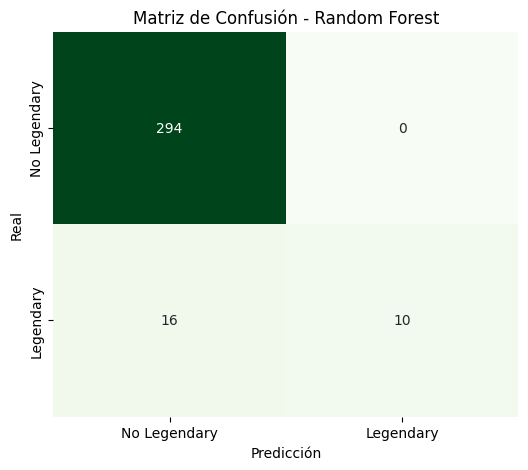

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

# Predicciones en test
rf_pred = rf.predict(X_test)

# Resultados
print("Precisión RF:", accuracy_score(Y_test, rf_pred))
print("\nReporte de clasificación RF:\n", classification_report(Y_test, rf_pred, target_names=target_names, digits=4))

# Matriz de confusión
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(Y_test, rf_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

### Tabla comparativa de metricas


|    **Métrica / Clase**     | **NN** | **RF** |
| :-----------------------: | :-------------: | :----: |
|        **Accuracy**       |      0.9531     | 0.9406 |
| **Precision (Legendary)** |      0.8667     | 0.6842 |
|   **Recall (Legendary)**  |      0.5000     | 0.5000 |
|     **F1 (Legendary)**    |      0.6341     | 0.5778 |
|   **Precision (NoLeg.)**  |      0.9574     | 0.9568 |
|    **Recall (NoLeg.)**    |      0.9932     | 0.9796 |
|      **F1 (NoLeg.)**      |      0.9750     | 0.9681 |
|        **Macro F1**       |      0.8046     | 0.7729 |
|      **Weighted F1**      |      0.9473     | 0.9364 |


Actualmente, la red nueronial (NN) supera al modelo de Random Forest (RF) en la mayoría de las métricas, especialmente en precisión y F1-score para la clase "Legendary". Esto sugiere que la red neuronal es más efectiva para identificar Pokémon legendarios, mientras que el modelo RF tiene un esta tarea específica. Sin embargo, ambos modelos muestran un buen rendimizento general, con una alta precisión y recall para la clase "NoLegendary".



## Problema 2

### Representaciones internas a partir de datos sin etiquetar  
En esta sección se trabajará con un enfoque diferente al utilizado previamente. Ahora no se utilizarán etiquetas para guiar el aprendizaje del modelo. En su lugar, el objetivo será encontrar una forma eficiente de representar cada instancia del dataset en un espacio de menor dimensión.

Diseñe un modelo que reduzca la dimensionalidad de los datos, y entrene dicho modelo utilizando el conjunto completo. Luego, visualice la representación de los datos en dos dimensiones. Para el resto siga un esquema similar al del problema anterior.

Responda las siguientes preguntas:
- ¿Se observan agrupaciones o patrones en la representación obtenida?
- ¿Es posible distinguir algún tipo de separación visual al colorear los puntos según si un Pokémon es legendario o no?
- ¿Qué interpretación podrías darle a la distribución resultante?
- ¿Sus resultados tienen alguna relación con el problema anterior?

R: 
**Para este problema, se utilizará un modelo de autoencoder (Undercomplete Autoencoder) para reducir la dimensionalidad del dataset**

In [36]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# Convertir las etiquetas de Y a números para usar con el modelo
label_encoder= LabelEncoder()
Y_num = label_encoder.fit_transform(Y) 

y_tensor = torch.tensor(Y_num, dtype=torch.long)

# crear dataloaders
# 1. Crea los datasets que alimentarán tu autoencoder (entrada == target)
train_ds = TensorDataset(X_train_t, X_train_t)
test_ds  = TensorDataset(X_test_t,  X_test_t)
# 2. Envuelve en DataLoader para batching y shuffle
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)


In [37]:
## Creacion Autoencoder

class PokemonAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(PokemonAutoencoder, self).__init__()
        # Codificador
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, latent_dim),
            nn.ReLU()
        )
        # Decodificador
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Sigmoid()  # usar Sigmoid si los datos están en [0,1]
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
    
    
# Crear el modelo
input_dim = X_train_t.shape[1]  # cantidad de features
model_ae = PokemonAutoencoder(input_dim, latent_dim=2)  # Definir el modelo con 64 neuronas en la capa oculta

In [38]:
## Entremamiento
criterion_ae = nn.MSELoss()  # Usar MSE para autoencoders
optimizer_ae = torch.optim.Adam(model_ae.parameters(), lr=1e-3)
## craear DataLoader para el autoencoder


def train_ae(model,dataloader,criterion,optimizer,num_epochs=20):
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        for xb, _ in dataloader:  # No necesitamos las etiquetas para el autoencoder
            xb = xb.float()
            optimizer.zero_grad()  # Reinicia los gradientes
            recon, _ = model(xb)             # <-- desempaqueta
            loss      = criterion(recon, xb)
            loss.backward()  # Backpropagation
            optimizer.step()  # Actualiza los parámetros
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch:02d} — Loss: {epoch_loss:.4f}")

# entrenar
train_ae(model_ae, train_loader, criterion_ae, optimizer_ae, num_epochs=100)

Epoch 01 — Loss: 1.2600
Epoch 02 — Loss: 1.2410
Epoch 03 — Loss: 1.2189
Epoch 04 — Loss: 1.1899
Epoch 05 — Loss: 1.1521
Epoch 06 — Loss: 1.1081
Epoch 07 — Loss: 1.0674
Epoch 08 — Loss: 1.0383
Epoch 09 — Loss: 1.0209
Epoch 10 — Loss: 1.0108
Epoch 11 — Loss: 1.0042
Epoch 12 — Loss: 0.9998
Epoch 13 — Loss: 0.9964
Epoch 14 — Loss: 0.9936
Epoch 15 — Loss: 0.9910
Epoch 16 — Loss: 0.9883
Epoch 17 — Loss: 0.9857
Epoch 18 — Loss: 0.9829
Epoch 19 — Loss: 0.9801
Epoch 20 — Loss: 0.9773
Epoch 21 — Loss: 0.9745
Epoch 22 — Loss: 0.9722
Epoch 23 — Loss: 0.9702
Epoch 24 — Loss: 0.9684
Epoch 25 — Loss: 0.9669
Epoch 26 — Loss: 0.9655
Epoch 27 — Loss: 0.9643
Epoch 28 — Loss: 0.9630
Epoch 29 — Loss: 0.9619
Epoch 30 — Loss: 0.9608
Epoch 31 — Loss: 0.9598
Epoch 32 — Loss: 0.9588
Epoch 33 — Loss: 0.9578
Epoch 34 — Loss: 0.9568
Epoch 35 — Loss: 0.9557
Epoch 36 — Loss: 0.9547
Epoch 37 — Loss: 0.9537
Epoch 38 — Loss: 0.9527
Epoch 39 — Loss: 0.9517
Epoch 40 — Loss: 0.9507
Epoch 41 — Loss: 0.9497
Epoch 42 — Loss:

In [39]:
# Evauar modelo
def evaluate_loader(model, dataloader):
    model.eval()
    latents, recons = [], []
    with torch.no_grad():
        for xb, _ in dataloader:
            xb = xb.float()
            recon, z = model(xb)
            recons.append(recon)
            latents.append(z)
    recons = torch.cat(recons, dim=0).cpu().numpy()
    latents= torch.cat(latents,dim=0).cpu().numpy()
    return recons, latents

# --- Ejecución ---
recons_test, latents_test = evaluate_loader(model_ae, test_loader)

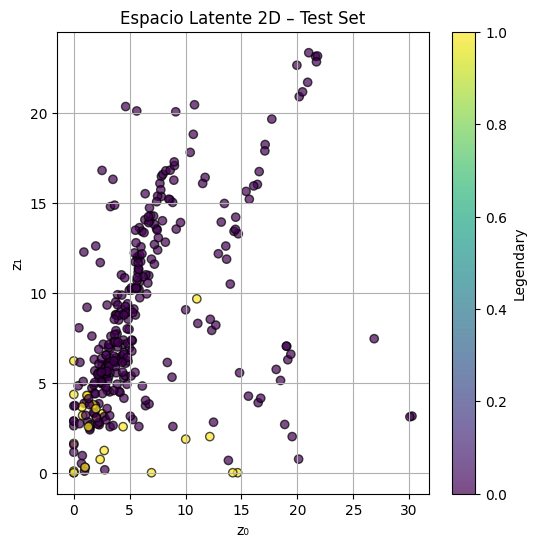

In [40]:
# 2. Convierte etiquetas de test a array (si aún están en tensor)
#    — ojo, si Y_test es tensor, haz Y_test.numpy(); si es lista/array ya sirve.
labels_test = Y_test  # o Y_test.numpy() según tu caso

# 3. Grafica
plt.figure(figsize=(6,6))
plt.scatter(
    latents_test[:, 0], latents_test[:, 1],
    c=labels_test,
    cmap='viridis',
    alpha=0.7,
    edgecolors='k',  # bordes pa’ que se note mejor
)
plt.title("Espacio Latente 2D – Test Set")
plt.xlabel("z₀")
plt.ylabel("z₁")
plt.colorbar(label="Legendary")
plt.grid(True)
plt.show()

1. ¿Se observan agrupaciones o patrones?
    
    Los puntos forman algo paracido a una "V",y ademas se ven dos brazos abiertos eso indica dos direcciones de variación principales en tus stats, esto encaja con descrito por analisis exploratorio, en especifico:
      - La media de stats ronda los 65–80, pero el rango va desde casi 0 hasta ~255.
      - Los outliers (p.ej. HP=255, Defense=230) caen en los extremos de esos brazos.
      - El vértice concentra la mayoría de Pokémon (los que tienen stats entre el 25 % y el 75 %, es decir valores “medios”).
  
2. ¿Se distingue separación visual legendario vs no–legendario?
    No se aprecia un cluster perfectamente aislado de amarillos ni de los morados; los legendarios (puntos amarillos) se mezclan con los morados. aunque los legendarios tienen a aparecer en zonas de stats altas cerca del > 75% en attack,sp. atk o speed.


3. ¿Qué interpretación le das a la distribución?
    Los extremos del abanico representan perfiles especializados:
    Un brazo para altos valores de defensa/HP (> 90, percentil 75 %).

    Otro para altos valores de ataque/velocidad (> 90, percentil 75 %).

    Dado que “Total” se eliminó, cada dimensión latente mezcla directamente los seis stats sin redundancia, iluminando esas dos direcciones de mayor variación.

